In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Standardised Fama French 5 to industry portfolio 30
# Import data
data = pd.read_pickle("/Users/sikai/Downloads/ff5_30_standard_4000_draws.pkl")

# # Restrict to 100 time points
X = data[10:110].transpose(2, 1, 0)
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [3]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

In [25]:
from regain.covariance import TaylorProxTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = TaylorProxTimeGraphicalLasso(max_iter=20000, loss='LL', c_level=0.2, rho=1e2, theta=0.5, tol=1e-4, rtol=1e-4, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))
# print(min_pre_tp)

0
-6.800177557476467 -7.727118895076989
50940.731002451
100
2.543267303765248 -1.40410365824892
34971.327616557464
199 28159.8425743385
32.121148236336964 0.1727897088111533
21243.377723613783 17.773967224974747
Running Time :128.15183749300013


/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/taylor_prox_time_graphical_lasso.py:337: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [17]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_tp_thres = {}
fit_score_tp_thres = {}
for i in [1e-2, 1e-3, 1e-4, 1e-6, 0]:
# for i in [min_pre_tp]:
    pre_tp_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tp])
    tgl.precision_ = pre_tp_thres[i]
    _, _, fit_score_tp_thres[i], _ = tgl.eval_cov_pre() 
    print(penalty_objective(pre_tp_thres[i], pre_tp_thres[i][:-1], pre_tp_thres[i][1:], psi, tgl.theta))

18923.920775625473
18926.92622046537
18926.978302007166
18926.980693419602
18926.980695781203


In [16]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
res = {}
for i in [1.]:
    tic = time.perf_counter()
    tgl = InequalityTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.2, c_prox='cvx', rho=1e2, div=i, tol=1e-4, rtol=1e-4, psi="laplacian")
    res[i] = tgl.fit_cov(X_cov).eval_cov_pre() 
    toc = time.perf_counter()
    print('Running Time :{}'.format(toc - tic))

719 36403.73730369657
7.647221177828824e-06 0.17359123542455224
0.054206383106336534 0.05455758099870649
Running Time :150.05007979499896


In [7]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl = InequalityTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, c_prox='grad', rho=5e3, theta=0.5, psi="laplacian")
emp_inv_score_grad, baseline_score_grad, fit_score_grad, pre_grad = tgl.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))

19999 15741.945195022443
6.935124293673753e-07 0.1609063459895989
49.63739338484345 0.046696337023818826
Running Time :2841.5648648160004


/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/inequality_time_graphical_lasso.py:267: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [8]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol_ff5_30_standard_alpha_0.2.npy")

In [9]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl.theta))

5951.380304945549


In [10]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

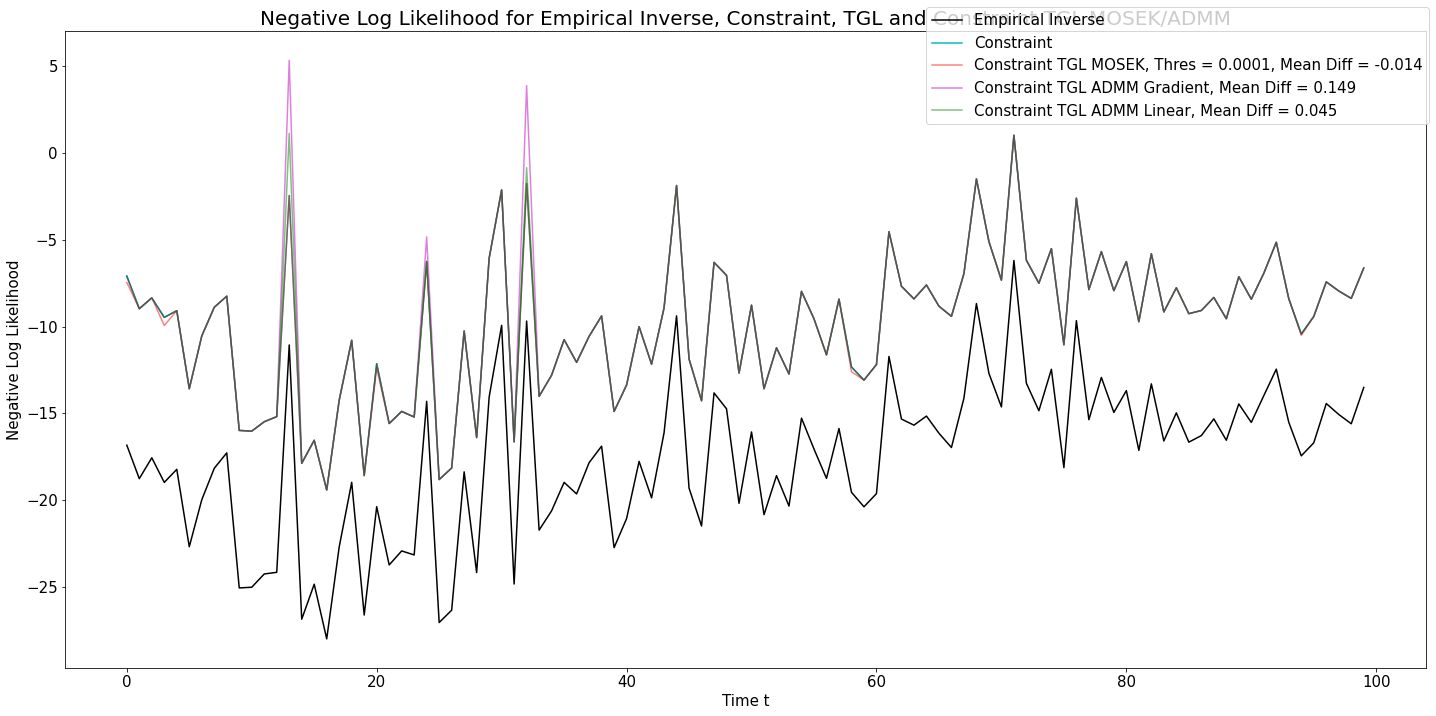

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), res[1][0], color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), res[1][1], color='c', label=r'Constraint')
for i in [1e-4]:
# for i in [1e-2, 1e-3, 1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# # for i in [2.]:    
# #     mean_diff = np.mean(np.array(res[i][2]) - res[i][1])
# #     ax.plot(range(X_cov.shape[-1]), res[i][2], alpha=0.5, color='g',
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
# # mean_diff = np.mean(np.array(fit_score_diff) - baseline_score)
# # ax.plot(range(n_time), fit_score_diff, alpha=0.5,
# #         label=r'Constraint TGL ADMM Difference, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_tp)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_) - res[1][1])
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
# ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_like_max_2_mult_2.pdf')
# plt.savefig('diff_like_{}_{}_scs.pdf'.format(dim_X, dim_fac))

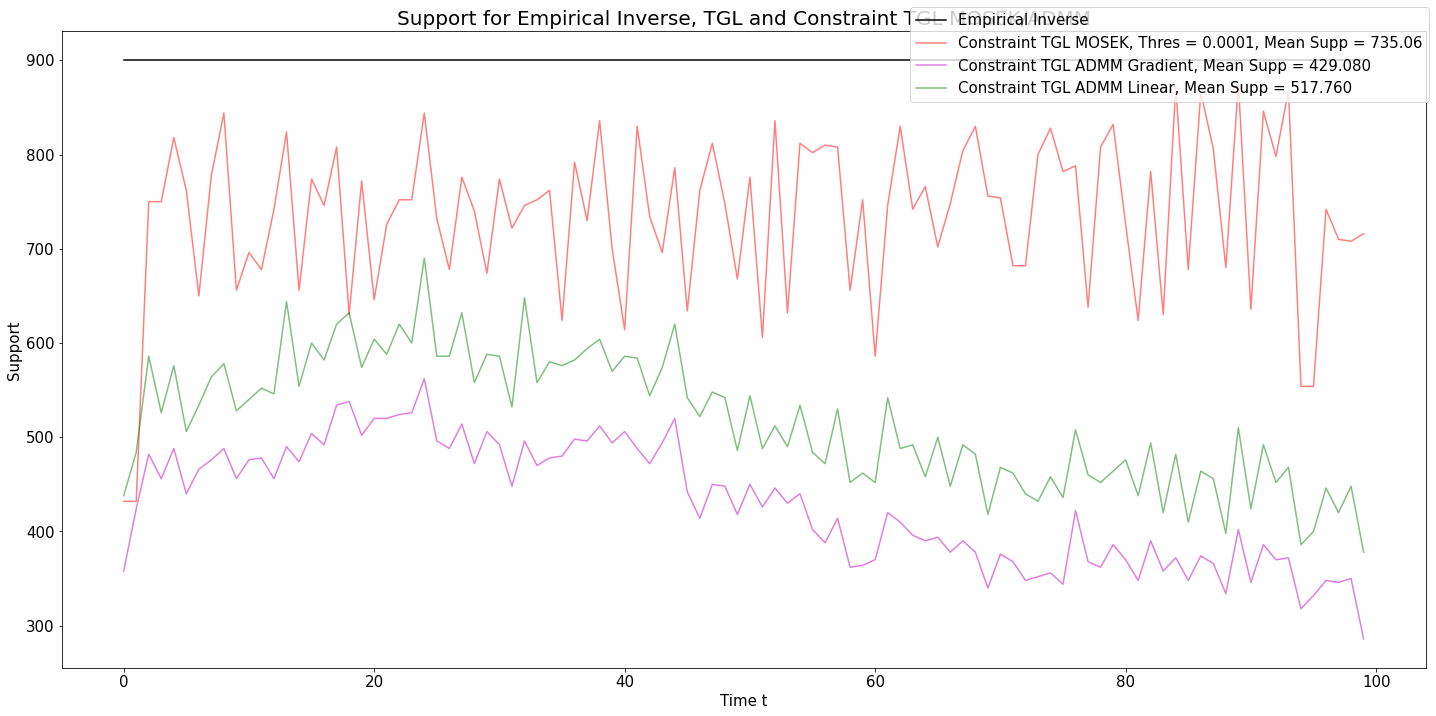

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# # for i in [2.]:    
# #     supp = [sum(sum(abs(res[i][3][t]) > 0)) for t in range(X_cov.shape[-1])]
# #     mean_supp = np.mean(supp)
# #     ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Supp = {:.3f}'.format(i, mean_supp))
supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tp_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
#         color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
# ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_supp_max_2_mult_2.pdf')
# plt.savefig('diff_supp_{}_{}_scs.pdf'.format(dim_X, dim_fac))

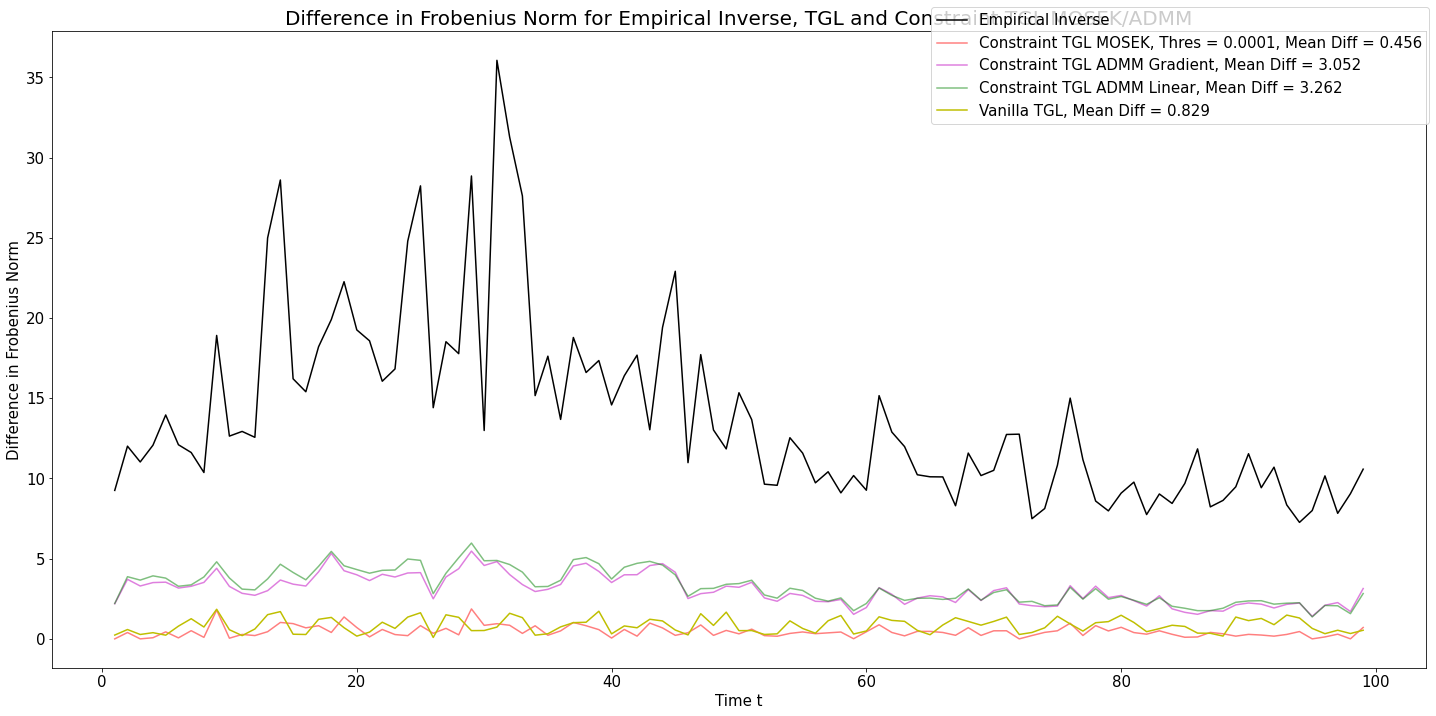

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [norm(emp_inv[t] - emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# # for i in [2.]:    
# #     diff_cvx = [norm(res[i][3][t] - res[i][3][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# #     ax.plot(range(1, X_cov.shape[-1]), diff_cvx, color='g', alpha=0.5,
# #             label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, np.mean(diff_cvx)))
diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
# ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_fro_max_2_mult_2.pdf')
# plt.savefig('diff_fro_{}_{}_scs.pdf'.format(dim_X, dim_fac))